Buddy needs these 3 files:

nodeCoords.mat contains x, y, both in mm.

actCoords.mat contains xAct, yAct, both in mm. 

SVD.mat contains the matrices U, S, V produced by the Matlab function 

In [18]:
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from M1S_tools import *

plt.jet()

%matplotlib inline

from scipy.io import savemat

<Figure size 640x480 with 0 Axes>

### actCoords.mat first

In [22]:
#Buddy provided these files right before OT started.
#most like they are identical to what he provided in 2023. But let's read these latest files, just to be sure
dataFolder = '/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents/'

Jan25MLFolder = 'M1 Testing/RFCML Optical Testing/Mirror Lab bending modes/'

#read SA data
dfSA = scipy.io.loadmat(dataFolder+Jan25MLFolder+'/actCoords.mat')
sax_ml = dfSA['yAct']/1e3 #turn into meter #swap x/y to get to M1B (M1DCS uses M1B!!!)
say_ml = dfSA['xAct']/1e3 #turn into meter
print('ML actuators = ', len(sax_ml), len(say_ml))


ML actuators =  165 165


In [3]:
def gmtActXY2mlActXY(gmtFvec):
    '''
    convert a GMT force vector (170x1) into a ML force vector (165x1)
    input:
        gmtFvec: GMT force vector (170x1)
    output:
        mlFvec: ML force vector (165x1)
    '''
    mlFvec = np.zeros(nact_ml)
    for i in range(nact_ml):
        idx = np.where(saID==(saID_ml[i]))[0]
        if len(idx) == 1:
            mlFvec[i] = gmtFvec[idx]
        if saID_ml[i]>1e6:
            idx1 = np.where(saID==(saID_ml[i]%1e6))[0] #e.g. saID_ml can be 144001144
            idx2 = np.where(saID==(saID_ml[i]//1e6))[0]
            if len(idx1) == 1:
                mlFvec[i] += gmtFvec[idx1]
            if len(idx2) == 1:
                mlFvec[i] += gmtFvec[idx2]
            mlFvec[i] /= 2
    return mlFvec

In [4]:
#we need to turn our 170 y values into ML 165 x values; also ML uses mm while we use meter.
xAct = gmtActXY2mlActXY(say)*1e3 
yAct = gmtActXY2mlActXY(sax)*1e3

In [5]:
xAct[:3], dfSA['xAct'][:3], np.array(dfSA['xAct']).shape

(array([ 3691.783,   996.957, -3693.202]),
 array([[ 3692.52246 ],
        [  997.693458],
        [-3692.46658 ]]),
 (165, 1))

which actuator's locations diff?


array([1412., 1112., 1312., 1212.])

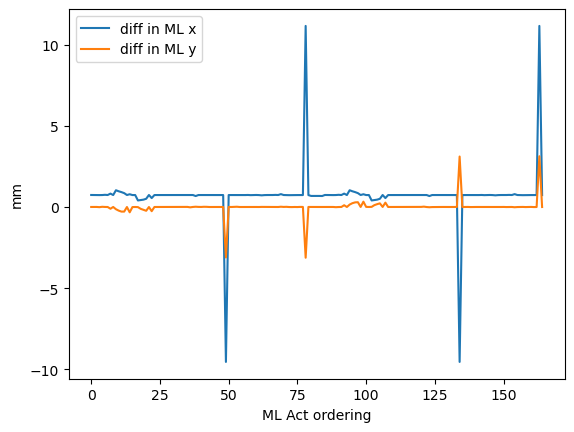

In [6]:
diffx = np.squeeze(np.array(dfSA['xAct']))-xAct
diffy = np.squeeze(np.array(dfSA['yAct']))-yAct
plt.plot(diffx, label='diff in ML x')
plt.plot(diffy, label='diff in ML y')
plt.legend()
plt.ylabel('mm')
plt.xlabel('ML Act ordering')
print('which actuator\'s locations diff?')
saID_ml[abs(diffx)>5]
#yes, this agrees with what we observed before.

### wait, I don't think we want to reorder the actuators to match ML. as long as we are self-consistent.

In [7]:
xAct = say.reshape(-1,1)*1e3 #make them 170x1 instead of 1x170, to be consistent with Buddy's mat files.
yAct = sax.reshape(-1,1)*1e3
print(xAct.shape)

(170, 1)


In [8]:
data = {'xAct': xAct, 'yAct': yAct}
savemat('actCoords_GMT.mat', data)

In [9]:
dfSA = scipy.io.loadmat('actCoords_GMT.mat')
dfSA

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Jan  6 08:26:23 2025',
 '__version__': '1.0',
 '__globals__': [],
 'xAct': array([[-7.494190e-01],
        [-7.399260e-01],
        [-7.305360e-01],
        [-7.429460e-01],
        [-7.337290e-01],
        [-6.652420e-01],
        [-5.773300e+02],
        [-5.773350e+02],
        [-5.773480e+02],
        [-5.773380e+02],
        [-5.773300e+02],
        [-5.773560e+02],
        [-1.153944e+03],
        [-1.153934e+03],
        [-1.153944e+03],
        [-1.153944e+03],
        [-1.153944e+03],
        [-9.982910e+02],
        [-1.730534e+03],
        [-1.730544e+03],
        [-1.730554e+03],
        [-1.730544e+03],
        [-1.730554e+03],
        [-1.518504e+03],
        [-2.307153e+03],
        [-2.307143e+03],
        [-2.307153e+03],
        [-2.307153e+03],
        [-2.167913e+03],
        [-2.883762e+03],
        [-2.883732e+03],
        [-2.883762e+03],
        [-2.802793e+03],
        [-2.745633e+03],
      

# nodeCoords.mat second

In [23]:
#read FEA nodes data
mat = scipy.io.loadmat(dataFolder+Jan25MLFolder+'/nodeCoords.mat')
nodex_ml = mat['y']/1e3 #turn into meter #swap x/y to get to M1B (M1DCS uses M1B!!!)
nodey_ml = mat['x']/1e3 #turn into meter
print('N node = ', len(nodex_ml))

N node =  6991


In [9]:
#read FEA nodes data
Dec24IFFolder = '/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_normalised_20Dec2024/'

df = pd.read_csv(dataFolder+Dec24IFFolder+'surfacenodes_M1B-20-Dec-2024.csv')
nodeID = np.array(df['nodeID'])
nodex = np.array(df['X'])
nodey = np.array(df['Y'])
nodez = np.array(df['Z'])
print('N node = ', len(nodeID), len(nodex))

N node =  28789 28789


In [10]:
# use these indices to remove surface nodes outside of CA
noder = np.sqrt(nodex**2+nodey**2)
insideCA = noder< np.max(nodex_ml) #diameter_of_CA/2.0
nodeID = nodeID[insideCA]
nodex = nodex[insideCA]
nodey = nodey[insideCA]
nodez = nodez[insideCA]

In [11]:
print(len(nodex), np.max(nodex))
x = nodey.reshape(-1,1)*1e3 #swap x,y, and turn meter into mm
y = nodex.reshape(-1,1)*1e3

27547 4.18097218296512


In [15]:
data = {'x': x, 'y': y}
savemat('nodeCoords_GMT.mat', data)

# SVD.mat third and last

In [24]:
#read Fz Bending Mode 
mat = scipy.io.loadmat(dataFolder+Jan25MLFolder+'/SVD.mat')
UMat_ml = mat['U']
SMat_ml = mat['S']
VMat_ml = mat['V']
print('U matrix', UMat_ml.shape)
print(SMat_ml.shape, VMat_ml.shape)
print(np.max(UMat_ml), np.max(SMat_ml), np.max(VMat_ml))

U matrix (6991, 165)
(165, 165) (165, 165)
0.09135223301207027 983.4108904783556 0.40516610071388


### generate our U,S,V matrices

In [25]:
#read Afz (Fz influence matrix) - 01/02/2025. Trupti confirmed on slack that this is surface normal
df = pd.read_csv(dataFolder+Dec24IFFolder+'Afz-20-Dec-2024.csv', header=None)
Afz = np.array(df)
print('Afz = ',Afz.shape)
# this is Afz only; it is 28789 x 176. last 6 being HPs

Afz = Afz[insideCA, :]
#this takes ~1 minute
#U, S, Vt = np.linalg.svd(Afz[:,:nact]) #here we exclude the HPs, because our force RMS should not include those

Afz = Afz[:,:nact] #here we exclude the HPs, because our force RMS should not include those
Afz[:,-10:] *= 2 #Trupti divided them by 2, which she shouldn't have. Let's put the factor of 2 back

#RFCML mode shapes are in nanometers, GMT uses meters
Afz *= 1e9
U, S, Vt = np.linalg.svd(Afz[:,:(nact)], full_matrices=False) 
print(U.shape, S.shape, Vt.shape)

Afz =  (28789, 176)
(27547, 170) (170,) (170, 170)


#### the ordering of the nodes is what it is. We already defined them in nodeCoords.mat

#### Do we need to shuffle the columns of S and rows of V? No. see my pptx for 1/16/25. The columns of Afz is already consistent with actCoords.mat

In [40]:
print(U.shape, S.shape, Vt.shape)
print(np.max(U), np.max(S), np.max(Vt))
print(np.std(UMat_ml[:,0])*np.sqrt(UMat_ml.shape[0]))
print(np.std(U[:,0])*np.sqrt(U.shape[0]))
print(np.diag(SMat_ml)[:5])
print(S[:5])

(27547, 170) (170,) (170, 170)
0.9072200869354443 2306.0695612489912 0.7041432512066129
0.9999999999999994
0.9999999992983112
[983.41089048 973.72700474 397.53158549 186.99313824 173.92290716]
[2306.06956125 2289.15698866  892.00909753  418.00789492  399.71815889]


In [41]:
#even after we've dealt with the x,y, the z axis is reversed.
#we could leave the U,V untouched at the same time. it will still work. 
#But this makes them consistent with what GMT uses
U = -U[:,:nact] 
Sigma = np.zeros((nact,nact))  # Create a matrix of zeros with the shape of A
np.fill_diagonal(Sigma, S)  # Place the singular values on the diagonal
S = Sigma
V= - Vt.T
print(U.shape, S.shape, V.shape)

(27547, 170) (170, 170) (170, 170)


In [42]:
data={'U':U, 'S':S, 'V':V}
savemat('SVD_GMT.mat', data)

In [20]:
saID

array([ 101,  102,  103,  104,  105,  106,  107,  108,  109,  110,  111,
        112,  114,  115,  116,  117,  118,  119,  120,  121,  122,  123,
        124,  125,  127,  128,  129,  130,  131,  132,  133,  134,  135,
        136,  137,  138,  139,  140,  141,  142,  143,  207,  208,  209,
        210,  211,  212,  214,  215,  216,  217,  218,  219,  220,  221,
        222,  223,  224,  225,  227,  228,  229,  230,  231,  232,  233,
        234,  235,  236,  237,  238,  239,  240,  241,  242,  243,  301,
        302,  303,  304,  305,  306,  307,  308,  309,  310,  311,  312,
        314,  315,  316,  317,  318,  319,  320,  321,  322,  323,  324,
        325,  327,  328,  329,  330,  331,  332,  333,  334,  335,  336,
        337,  338,  339,  340,  341,  342,  343,  407,  408,  409,  410,
        411,  412,  414,  415,  416,  417,  418,  419,  420,  421,  422,
        423,  424,  425,  427,  428,  429,  430,  431,  432,  433,  434,
        435,  436,  437,  438,  439,  440,  441,  4